## About
OCR(Text recognition from Images) using Keras

Dataset - https://www.kaggle.com/datasets/ssarkar445/handwriting-recognitionocr


In [34]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import glob
import pandas as pd
from tensorflow.keras import layers
from pathlib import Path
from collections import Counter
from keras.layers import Conv2D, MaxPooling2D, Dense,Dropout, Bidirectional,LSTM,Reshape, add, concatenate, Lambda, Flatten
from tensorflow.keras.layers import BatchNormalization
import keras.backend as K


In [35]:
# #extracting dataset
#os.chdir('/content/drive/MyDrive/Datasets')
#!unzip ocr_data.zip

In [36]:
dataset_path = "/home/suraj/ClickUp/Jan-Feb/data/ocr_data"
#reading the csv 
train_csv = "written_name_train.csv"
val_csv = "written_name_validation.csv"

In [37]:
train_df = pd.read_csv(dataset_path+"/"+train_csv)
train_df.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [38]:
val_df = pd.read_csv(dataset_path+"/"+val_csv)
val_df.head()

,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP


/home/suraj/ClickUp/Jan-Feb/data/ocr_datatrain/TRAIN_00001.jpg


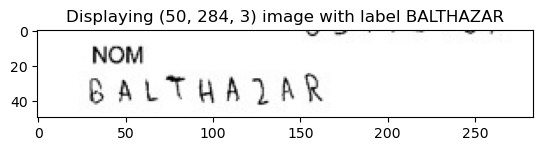

/home/suraj/ClickUp/Jan-Feb/data/ocr_datatrain/TRAIN_00002.jpg


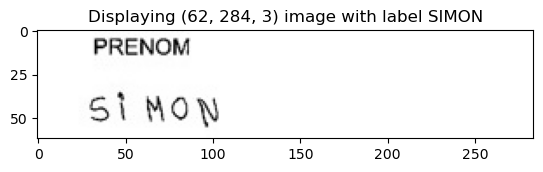

/home/suraj/ClickUp/Jan-Feb/data/ocr_datatrain/TRAIN_00003.jpg


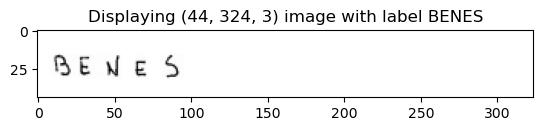

/home/suraj/ClickUp/Jan-Feb/data/ocr_datatrain/TRAIN_00004.jpg


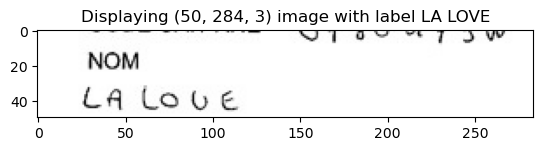

/home/suraj/ClickUp/Jan-Feb/data/ocr_datatrain/TRAIN_00005.jpg


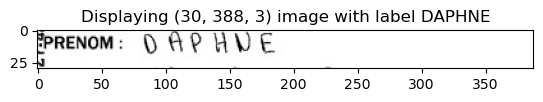

/home/suraj/ClickUp/Jan-Feb/data/ocr_datatrain/TRAIN_00006.jpg


In [39]:
#displaying few images from train set
disp_count =0
for idx in range(len(train_df.FILENAME)):
    file_name = train_df['FILENAME'][idx]
    label = train_df['IDENTITY'][idx]
    #print(dataset_path+'train/'+file_name)
    image = cv2.imread(dataset_path+'/train/'+file_name)
    print(dataset_path+'train/'+file_name)
    if disp_count!=5:
        plt.title('Displaying {} image with label {}'.format(image.shape,label))
        plt.imshow(image)
        plt.show()
        disp_count+=1
    else:
        break

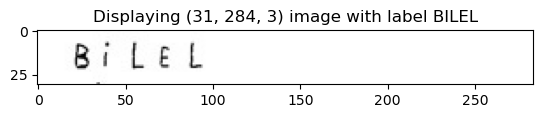

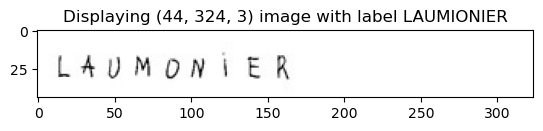

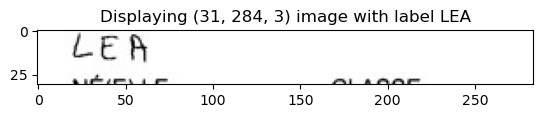

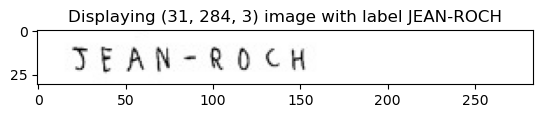

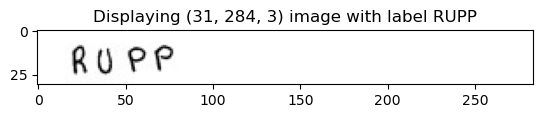

In [40]:
#displaying few images from train set
disp_count =0
for idx in range(len(val_df.FILENAME)):
    file_name = val_df['FILENAME'][idx]
    label = val_df['IDENTITY'][idx]
    image = cv2.imread(dataset_path+'/validation/'+file_name)
    if disp_count!=5:
        plt.title('Displaying {} image with label {}'.format(image.shape,label))
        plt.imshow(image)
        plt.show()
        disp_count+=1
    else:
        break

In [41]:
#creating list of image name and labels for train set
for file_name in glob.glob('/home/suraj/ClickUp/Jan-Feb/data/ocr_data/written_name_train.csv'):
  df = pd.read_csv(file_name)
  print(len(df))
  train_image_names = df['FILENAME'].values.tolist()
  train_labels = df['IDENTITY'].values.tolist()

330961


In [42]:
#creating list of image name and labels for val set
for file_name in glob.glob('/home/suraj/ClickUp/Jan-Feb/data/ocr_data/written_name_validation.csv'):
  df = pd.read_csv(file_name)
  val_image_names =df['FILENAME'].values.tolist()
  val_labels = df['IDENTITY'].values.tolist()

In [43]:
np.shape(train_image_names)

(330961,)

In [44]:
#statistics
print("{} number of train_images and {} number of train labels".format(len(train_image_names),len(train_labels)))
#statistics
print("{} number of val_images and {} number of val labels".format(len(val_image_names),len(val_labels)))

330961 number of train_images and 330961 number of train labels
41370 number of val_images and 41370 number of val labels


In [45]:
#breaking down labels to characters for train set
train_char_list = []
for label in train_labels:
  #print(label.split())
  label = str(label)
  label = [*label]
  for char in label:
    train_char_list.append(char)
    
unique_train_chars = set(train_char_list)

In [46]:
print(unique_train_chars)

{'l', 'i', 'S', 'Q', 'P', 'a', 'y', 'L', 'D', 'X', 'Y', 'E', 'C', 'V', 'O', 'F', 'o', 'p', 'r', 'M', 'g', 'W', 'A', 'U', 'G', 'T', ' ', 'h', 'b', 'K', 'Z', 'I', 'N', 'c', '-', 'u', 'm', 'v', 'f', 't', 'n', 'R', 'e', 's', '`', 'H', 'J', 'z', 'B', "'"}


In [47]:
print(len(unique_train_chars))

50


In [48]:
#breaking down labels to characters for val set
val_char_list = []
for label in val_labels:
  #print(label.split())
  label = str(label)
  label = [*label]
  for char in label:
    val_char_list.append(char)
    
unique_val_chars = set(val_char_list)

In [49]:
characters = unique_train_chars.union(unique_val_chars)

In [50]:
print(len(characters))

50


In [51]:
#helper functions to map characters to num and numbers to characters
#1. Encoder function converts characters to integers
encoder_function = layers.experimental.preprocessing.StringLookup(vocabulary = list(characters), num_oov_indices=0, mask_token=None)
#2. decoder function converts integers to original characters
decoder_function = layers.experimental.preprocessing.StringLookup(vocabulary=encoder_function.get_vocabulary(),mask_token=None, invert=True)

In [53]:
#encoder
def encoder_train(img_path,label,img_width = 400,img_height = 100): #train,validation
  img_path = '/home/suraj/ClickUp/Jan-Feb/data/ocr_data/train/'+img_path #converting to absolute path
  #print(img_path)
  img = tf.io.read_file(img_path)

  #converting to gray scale
  img = tf.io.decode_jpeg(img,channels=1)
  #converting to float32
  img = tf.image.convert_image_dtype(img,tf.float32)
  #resizing
  img = tf.image.resize(img,[img_height,img_width])
  #transpose since we will want time dimension to correspond to width and thus process letters
  img = tf.transpose(img,perm=[1,0,2])
  # encoding labels
  label = encoder_function(tf.strings.unicode_split(label,input_encoding="UTF-8"))

  return {"image":img, "label":label}


In [54]:
def encoder_val(img_path,label,img_width = 400,img_height = 100): #train,validation
  img_path = '/home/suraj/ClickUp/Jan-Feb/data/ocr_data/validation/'+img_path #converting to absolute path
  img = tf.io.read_file(img_path)
  #converting to gray scale
  img = tf.io.decode_jpeg(img,channels=1)
  #converting to float32
  img = tf.image.convert_image_dtype(img,tf.float32)
  #resizing
  img = tf.image.resize(img,[img_height,img_width])
  #transpose since we will want time dimension to correspond to width and thus process letters
  img = tf.transpose(img,perm=[1,0,2])
  # encoding labels
  label = encoder_function(tf.strings.unicode_split(label,input_encoding="UTF-8"))

  return {"image":img, "label":label}


In [55]:
train_batch_size,val_batch_size=16,4

downsample = 4
max_train_label_length = max([len(train_labels) for label in train_labels])
max_val_label_length = max([len(val_labels) for label in val_labels])
#converting to array
train_image_names = np.array(train_image_names)
train_labels = np.array(train_labels)
val_image_names = np.array(val_image_names)
val_labels = np.array(val_labels)
# Creating dataset object
train_data = tf.data.Dataset.from_tensor_slices((train_image_names,train_labels))
train_data = (
    train_data.map(
        encoder_train, num_parallel_calls= tf.data.experimental.AUTOTUNE
    ).batch(train_batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)


val_data = tf.data.Dataset.from_tensor_slices((val_image_names,val_labels))
val_data = (
    val_data.map(
        encoder_val, num_parallel_calls= tf.data.experimental.AUTOTUNE
    ).batch(val_batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [ ]:
for batch in train_data.take(5):
  print(batch['image'].shape, batch['label'].shape)
  break

In [ ]:
for i,batch in enumerate(val_data):
  print(batch['image'].shape, batch['label'].shape)
  if i ==2:
    break

In [ ]:
# CTC layer
class CTCLayer(layers.layer):
  def __init__(self):
    super().__init__
    self.loss_function = keras.backend.ctc_batch_cost

  def call(self,y_true,y_pred):
    #modifying the shapes
    batch_len = tf.cast(tf.shape(y_true)[0],dtype="int64")
    input_len = tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_len = tf.cast(tf.shape(y_true)[1],dtype="int64")
    input_len = input_len * tf.ones(shape=(batch_len,1),dtype="int64")
    label_len = label_len * tf.ones(shape=(batch_len,1),dtype="int64")

    loss = self.loss_function(y_true,y_pred,input_len,label_len)
    self.add_loss(loss)

    return y_pred

In [ ]:
# defining the model architecture
img_width = 400
img_height = 100
input_img = layers.Input(shape=(img_width,img_height,1),name="input",dtype="float32")
labels = layers.Input(shape=(None,), name="label",dtype="float32")

#1. Conv2D
out = Conv2D(64,(3,3),activation="relu",kernel_initializer='glorot_uniform',padding='same',name="conv1")(input_img)
#2. Batch normalisation
out = BatchNormalization()(out)
#3. Pooling
out = MaxPooling2D((2,2),name="pool1")(out)
#4. Conv2D
out = Conv2D(128,(3,3),activation="relu",kernel_initializer='glorot_uniform',padding='same',name="conv2")(out)
#5. Batch normalisation
out = BatchNormalization()(out)
#6. Pooling
out = MaxPooling2D((2,2),name="pool2")(out)
#7. reshaping
out = layers.Reshape(target_shape=((img_width // 4), (img_height // 4) *128),name="reshape_layer")(out)
#8. Dense
out = Dense(128,activation="relu",name="dense1")(out)
#9. Dropout
out = Dropout(0.2)(out)
#10. RNNs
out = Bidirectional(LSTM(256, return_sequences=True, dropout=0.25))(out)
out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(out)
#11. Dense
out = Dense(len(characters)+1,activation="softmax",name="dense2")(out)
#12. CTC layer
out = CTCLayer()(labels,out)

#stitching I/o in model
model = keras.models.Model(
    inputs=[input_img, labels], outputs=out
)

optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer)


In [ ]:
model.summary()

In [ ]:
#training the network
num_epochs=100
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(train_data,validation_data=val_data, epochs=num_epochs,callbacks=[early_stopping])


In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.save('text_recog.h5')

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(model.get_layer(name="input").input, model.get_layer(name="dense2").output)
prediction_model.summary()

## Predictions

In [ ]:
# prediction on test_dataset

#creating list of image name and labels for val set
for file_name in glob.glob('/content/drive/MyDrive/Datasets/ocr_data/written_name_test.csv'):
  df = pd.read_csv(file_name)
  test_image_names =df['FILENAME'].values.tolist()
  test_labels = df['IDENTITY'].values.tolist()

In [ ]:
print("{} number of test_images and {} number of test labels".format(test_image_names,test_labels))

In [ ]:
#breaking down labels to characters for train set
test_char_list = []
for label in test_labels:
  for char in label:
    test_char_list.append(char)

unique_test_chars = set(test_char_list)

In [ ]:
def encoder_test(img_path,label,img_width = 400,img_height = 100): #train,validation
  img_path = '/home/suraj/ClickUp/Jan-Feb/data/ocr_data/test/'+img_path #converting to absolute path
  img = tf.io.read_file(img_path)
  #converting to gray scale
  img = tf.io.decode_jpeg(img,channels=1)
  #converting to float32
  img = tf.image.convert_image_dtype(img,tf.float32)
  #resizing
  img = tf.image.resize(img,[img_height,img_width])
  #transpose since we will want time dimension to correspond to width and thus process letters
  img = tf.transpose(img,perm=[1,0,2])
  # encoding labels
  label = encoder_function(tf.strings.unicode_split(label,input_encoding="UTF-8"))

  return {"image":img, "label":label}


In [ ]:
test_batch_size=16
max_val_label_length = max([len(test_labels) for label in test_labels])

# Creating dataset object
test_data = tf.data.Dataset.from_tensor_slices((test_image_names,test_labels))
test_data = (
    test_data.map(
        encoder_test, num_parallel_calls= tf.data.experimental.AUTOTUNE
    ).batch(test_batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)


In [ ]:
for i,batch in enumerate(test_data):
  print(batch['image'].shape, batch['label'].shape)
  if i ==2:
    break

In [ ]:
max_length = max([len(test_labels) for label in test_labels])


In [ ]:
#decoder
def decode(pred):
  input_len = np.ones(pred.shape[0])* pred.shape[1]
  results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
  output_text = []
  for res in results:
    res = tf.strings.reduce_join(decoder_function(res)).numpy().decode("utf-8")
    output_text.append(res)
  return output_text

In [ ]:
for batch in test_data.take(5):
  batch_images = batch["image"]
  batch_labels = batch["labels"]

  preds = prediction_model.predict(batch_images)
  prediction_text = decode(preds)
                           

  original_texts = []
  for label in batch_labels:
    label = tf.strings.reduce_join(decoder_function(label)).numpy().decode("utf-8")
    original_texts.append(label)
  
  _, ax = plt.subplots(4,4,figsize=(10,10))
  for i in range((len(prediction_text)):
    img =(batch_images[i,:,:,0]*255).numpy().astype(np.uint8)
    img = img.T
    title= "predicted text is {}".format(prediction_text)
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")

plt.show()

## End Remarks

For further improvement, Refer -https://github.com/janzd/CRNN